# Redes convolucionales

Las redes convolucionales toman su nombre del concepto de convolución de funciones. Una convolución es un operador que toma una función y arroja una nueva función en base a kernel (o filtro). En sentido estricto, las redes convolucionales implementan el operador de correlación cruzada, pero llamaremos a estas capas convolucionales. 

Las redes convolucionales son especialmente importante para las imágenes, pues la convolución es una operación que es equivariante ante translaciones. Es decir, si $T$ es una traslación, entonces $f(Tx) = Tf(x)$, donde $f$ es la convolución y $x$ la imagen de entrada. Esto permite un procesamiento más preciso de las imágenes. Las redes convolucionales, por último, surgen desde una perspectiva biológica (LeCun et al., 1998).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from node_layers import *

## Funciones auxiliares

Definimos dos funciones auxiliares para nuestra implementación de nuestra red neuronal recurrente. La primera de estas funciones <tt>calculate_target_size</tt> se encarga en obtener el tamaño del tensor (imagen) resultante de la convolución, pues la convolución suele reducir el tamaño de la entrada.

La segunda función es la función de activación ReLU que se aplica en las capa convolucionales; aunque pueden aplicarse otras funciones de activación, la función ReLU suele ser la más común en redes convolucionales. Aquí, la incorporamos dentro de la misma capa convolucional.

In [2]:
def calculate_target_size(img_size, kernel_size):
    """Función que calcula las dimensiones de la imagen resultante de la convolución"""
    num_pixels = 0
    for i in range(img_size):
        added = i + kernel_size
        if added <= img_size:
            num_pixels += 1
            
    return num_pixels

#Definición de la función ReLU
ReLU = lambda x: np.array([np.max([0,c]) for c in x.reshape(x.shape[0]*x.shape[1])]).reshape(x.shape[0],x.shape[1])

## Capa convolucional

La capa convolucional implementa en el forward la aplicación de la convolución sobre un tensor de entrada. El forward y el backward se implementan de la siguiente forma:

* <b>Forward</b>: En esta capa se rquiere de un kernel $w$, el cual puede verse como una matriz de pesos, además de un bias $b$. La convolución, dado un tensor de entrada, se estima como: $$(w*x)_{i,j} = \sum_{l=1} \sum_{l'=1} w_{l,l'} x_{i+l, i+l'} + b$$ Posteriomente, aplicamo la función de activación ReLU: $$h_{i,j} = ReLU\big( (w*x)_{i,j} \big)$$

* <b>Backward</b>: El backward es similar a la de las redes feedforward, pero considerando que se tienen capas con conexiones dispersas. Por ejemplo, si $h_{i,j}$ es una neurona de la capa superior, las neuronas de la capa previa son sólo aquellas que se conectan con esta neurona; es decir, su derivada está dada como: $$\frac{h_{i,j}}{w_{i,j}} = ReLU' \sum_{a,b} x_{a+i,b+j}$$ Donde $x_{a+i,b+j}$ son todas los valores de la entrada que multiplican al peso $w_{i,j}$ (pues este se mueve a través de la imagen de entrada y dependiendo del tamalo del kernel, éste multiplicara un conjunto de píxeles).

In [3]:
class Conv2D():
    """Capa de convolución (cross correlation)"""
    def __init__(self, kernel):
        np.random.seed(1)
        #Inicialización de parámetros
        self.w = np.random.random((kernel, kernel))/np.sqrt(kernel)
        self.b = np.random.random(1)
        
    def __call__(self, x):
        #Convolución
        self.x = x
        self.tgt_size = calculate_target_size(x.shape[0], self.w.shape[0])
        self.k = self.w.shape[0]
        self.h = np.zeros(shape=(self.tgt_size, self.tgt_size))
        for i in range(self.tgt_size):
            for j in range(self.tgt_size):
                x_ij = x[i:i+self.k, j:j+self.k]           
                self.h[i, j] = np.sum(self.w*x_ij) + self.b
        
        return ReLU(self.h)
        
    def backward(self, layer, lr=0.1):
        #Paso backward
        self.d = 0
        for i in range(self.tgt_size):
            for j in range(self.tgt_size):
                if self.h[i,j] > 0:
                    dw = (layer.d@x[i:i+self.k, j:j+self.k]).sum(2)
                    self.w -= lr*dw
                    self.b -= lr*dw.sum()
                    self.d += dw

### Pooling

Posterior a la convolución, el resultado de esta capa suele pasar por una capa de pooling. Aquí implementamos el average pooling. El average pooling es de la forma:

$$h_{i,j} = \frac{1}{m\cdot m} \sum_{l=i}^m \sum_{l'=j}^m x_{l,l'} $$

Es decir, obtiene el promedio de los valores de $x_{l,l'}$ en una ventana de tamaño $m$. Por tanto, su derivada sobre $x$ es simplemente el valor del promedio.

In [4]:
class Pooling():
    """Aplicación de average pooling"""
    def __init__(self, size):
        #Tamaño de la ventana de pooling
        self.K, self.L = size, size
        
    def __call__(self, x):
        #Forward del pooling
        self.x = x
        self.M, self.N = x.shape
        self.MK = self.M // self.K
        self.NL = self.N // self.L
        self.h = x[:self.MK*self.K, :self.NL*self.L].reshape(self.MK, self.K, self.NL, self.L).mean(axis=(1, 3))

        return self.h
    
    def backward(self, layer):
        #Backward del poolin
        dh = self.h.reshape(self.MK*self.NL)/self.MK*self.NL
        self.d = np.outer(layer.d, dh).sum(0).reshape(self.MK, self.NL)

## Aplicación de la red convolucional

A continuación aplicamos la red a un problema específico. La implementación de la red, como en casos anteriores, se da con una gráfica computacional.

### Datos

Los datos responden al dataset MNIST que representa los números del 0 al 9 en manuscrito. El objetivo es predecir el número de la imagen. 

In [5]:
#Carga los datos
x,y = load_digits().data, load_digits().target
x = x.reshape(len(x),8,8)
#Genera entrenamiento y evaluación
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

### Entrenamiento

Construimos ahora el modelo a partir de una gráfica computacional que se compone de: 
1. Una capa convolucional que toma al imagen de entrada.
2. Una capa de pooling
3. Una capa lineal con activación de tangente hiperbólica.
4. Una capa de salida con activación softmax
5. La función de riesgo de entropía cruzada

Finalmente, entrenamos por un número de épocas dado y una rango de aprendizaje.

100%|█████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


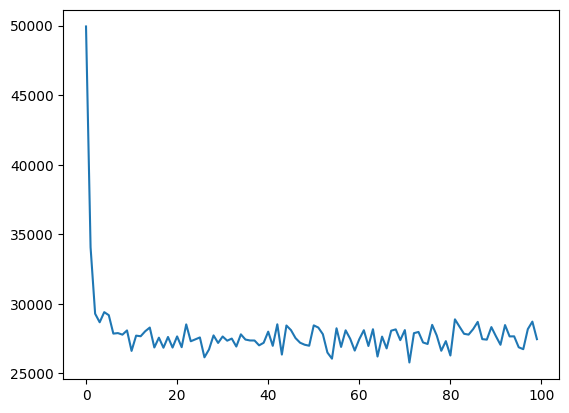

In [6]:
#Crea la gráfica de la red
conv = Conv2D(3)
pool = Pooling(2)
lin = Linear(9,10)
soft = Softmax()
risk = CrossEntropy()
#Hiperparámetros
lr = 0.1
epochs = 100
total_risk = []
for t in tqdm(range(epochs)):
    epoch_loss = 0
    for xi, yi in zip(x_train,y_train):
        #Forward
        h = conv(xi)
        pool_h = pool(h)
        flat_h = pool_h.reshape(9)
        f = soft(lin(flat_h))
        epoch_loss += risk(yi,f)
        
        #Backward
        risk.backward()
        soft.backward(risk)
        lin.backward(soft, lr=lr)
        pool.backward(lin)
        conv.backward(pool, lr=lr)
    total_risk.append(epoch_loss)

plt.plot(total_risk)

### Evaluación

Utilizamos el método de <tt>classification_report</tt> para evaluar el resultado de nuestra red convolucional en el conjunto de evaluación.

In [7]:
from sklearn.metrics import classification_report

#Predición en el test set
y_pred = [soft(lin(pool(conv(x_i)).reshape(9))).argmax() for x_i in x_test]
#Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        48
           1       0.83      0.66      0.74        59
           2       0.89      1.00      0.94        62
           3       0.82      0.86      0.84        42
           4       0.90      0.84      0.87        63
           5       0.84      0.66      0.74        64
           6       0.83      0.95      0.88        55
           7       0.80      0.92      0.85        38
           8       0.84      0.73      0.78        51
           9       0.79      0.90      0.84        58

    accuracy                           0.84       540
   macro avg       0.84      0.85      0.84       540
weighted avg       0.84      0.84      0.84       540



También podemos visualizar el kernel aprendido por la red convolucional. O mejor dicho, qué es lo que la capa convolucional regresa antes de pasar al pooling. Asimismo, podemos ver cómo trabaja el pooling.

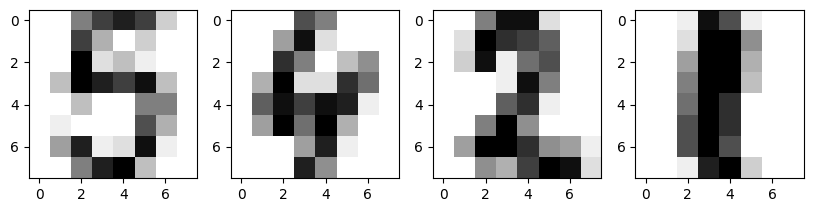

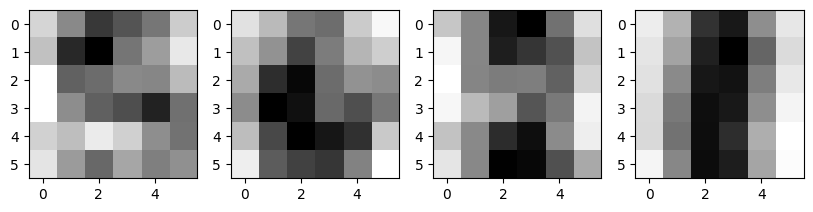

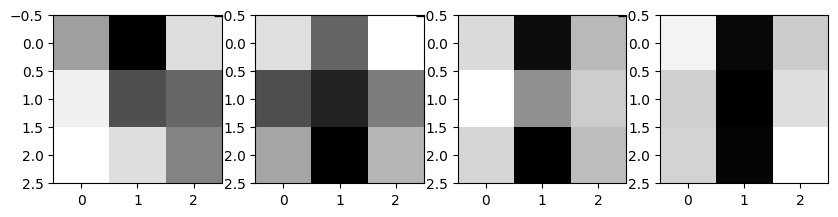

In [8]:
def plot_images(images, num=2):
    """Visualización de imagenes"""
    _, axes = plt.subplots(nrows=1, ncols=num, figsize=(10, 3))
    for ax, image in zip(axes, images):
        #ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        
plot_images(x_test[:4], num=4)
plot_images([conv(xi) for xi in x_test[:4]], num=4)
plot_images([pool(conv(xi)) for xi in x_test[:4]], num=4)

### Ejercicio

La implementación de la capa convolucional aquí expuesta trabaja con matrices; asume que la imagen es una matriz donde cada píxel es un escalar. Implementa una versión de capa convolucional que pueda trabajar con tensores: imágenes RGB o RGB-$\alpha$.